# Performance Prediction Analysis

## Questions/Ideas
- model selection: parametric vs non-parametric
- difficult to select good bandwidth programmatically
- take mean/median runtime?
- weighted least squares: some scale-outs more important to get right
- developement of prediction interval: from few to many data points
- outlier detection

In [1]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

import numpy as np
import scipy as sp
import scipy.interpolate
import pandas as pd

import sklearn as skl
import sklearn.linear_model, sklearn.pipeline, sklearn.cross_validation, sklearn.gaussian_process

import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std

In [2]:
def fmap(x):
    return np.c_[np.ones_like(x), 1./x]

def ols(x, y, x_predict, fmap, plot=False, ax=None):

    # fit OLS
    X = fmap(x)
    ols_model = sm.OLS(y, X)
    result = ols_model.fit()

    # predict OLS
    X_predict = fmap(x_predict)
    y_predict = result.predict(X_predict)
    prstd, iv_l, iv_u = wls_prediction_std(result, exog=X_predict)
    
    # plot OLS
    if plot:
        if ax is None:
            ax = plt.gca()    

        ax.fill_between(x_predict, iv_u, iv_l, color='gray', alpha=.2, label='95% PI')
        ax.plot(x, y, 'x', label='data')
        ax.plot(x_predict, y_predict, 'r', label='OLS')
        ax.legend()

        return result, ax
    
    return result

In [3]:
def ols_experiment(x, y, idxs, fmap):
    xmin, xmax = x.min(), x.max()
    ymin, ymax = 0, y.max()*1.5
    
    x_predict = np.linspace(x.min(), x.max(), 100)
    
    plt.figure(figsize=(13,3))
    for i, idx in enumerate(idxs):
        xi, yi = x[idx], y[idx]
        ax = plt.subplot(1, len(idxs), i+1)
        ols(xi, yi, x_predict, fmap, plot=True, ax=ax)
        ax.set_xlim(xmin, xmax)
        ax.set_ylim(ymin, ymax)
    
    plt.tight_layout()
    plt.show()

In [4]:
def remove_outlier_runs(data):
    x, y = data[:,0], data[:,1]
    data_wo = []
    for so in np.unique(x):
        rt = np.sort(data[x==so,1])[1:-1]
        data_wo.append(np.c_[so*np.ones_like(rt),rt])
    return np.vstack(data_wo)

## Developement of the Prediction Interval with Increasing Amount of Data

The following plots demostrate that an early prediction interval (PI) might not reflect the true uncertainity behind the runtimes.

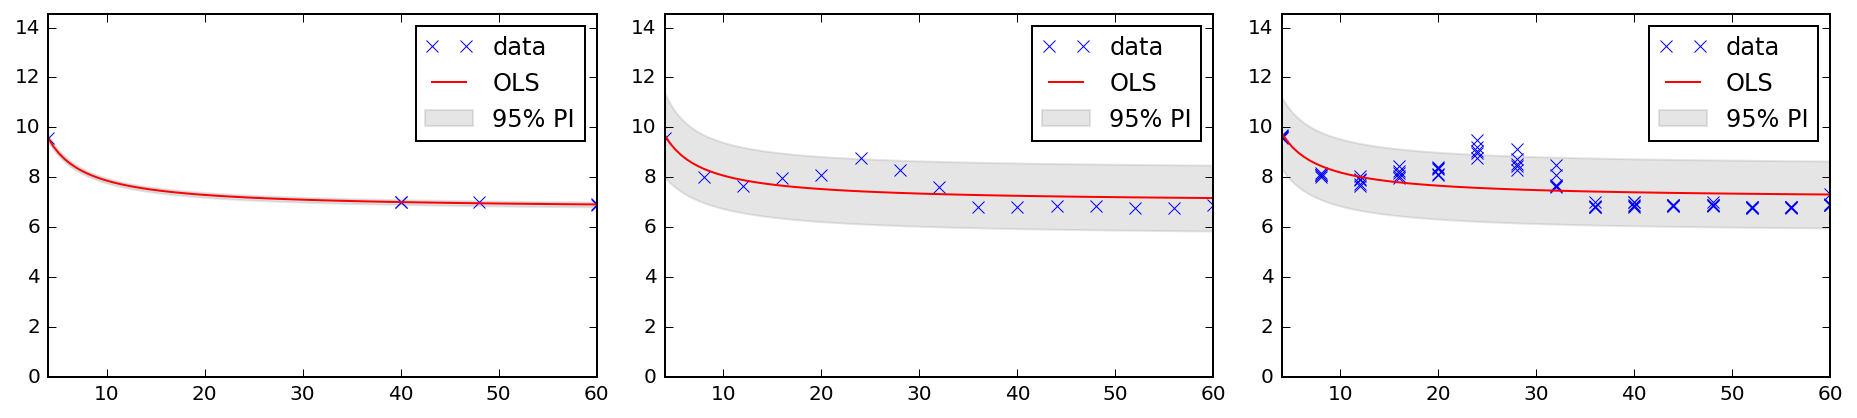

In [5]:
np.random.seed(10000)

df = pd.read_csv('tpchq10.flink.csv')
data = df.values
data = remove_outlier_runs(data)

x, y = data[:,0], data[:,1]/60000.

idx1 = np.random.permutation(x.size)[:6]
idx2 = np.arange(0, x.size, 5)
idx3 = np.arange(x.size)

ols_experiment(x, y, [idx1, idx2, idx3], fmap)

## TODO

In [ ]:
x, y = data[:,0], data[:,1]/60000.
plt.plot(x, y, 'x')
plt.ylim(ymin=0)

bw = 3.5

kr = sm.nonparametric.KernelReg(y, x, 'c', reg_type='ll', bw=[bw])
x_predict = np.linspace(x.min(), x.max(), 100)
mean, mfx = kr.fit(x_predict)
plt.plot(x_predict, mean)

plt.show()


def cv(x, y, bw, plot=False):

    errs = []
    
    folds = []
    #scale_outs = np.unique(x)
    #for i in range(len(scale_outs)):
    #    scale_out = scale_outs[i]
    #    runtimes = y[x==scale_out]        
    #    folds.append(np.c_[scale_out*np.ones_like(runtimes), runtimes])
    d = np.c_[x,y]
    idx = np.random.permutation(d.shape[0])
    for i in range(3):
        fold_idx = idx[i*(x.shape[0]/3):(i+1)*(x.shape[0]/3)]
        folds.append(d[fold_idx,:])

    for i in range(len(folds)):
        data_test = folds[i]
        data_train = np.vstack(folds[:i]+folds[i+1:])

        kr = sm.nonparametric.KernelReg(data_train[:,1], data_train[:,0], 'c', reg_type='ll', bw=[bw])
        y_predict, _ = kr.fit(data_test[:,0])
        ls_err = np.mean((y_predict - data_test[:,1])**2)
        errs.append(ls_err)
        
        if plot:
            plt.plot(data_train[:,0], data_train[:,1], 'x')
            plt.ylim(ymin=0)
            x_predict = np.linspace(x.min(), x.max(), 100)
            y_predict, _ = kr.fit(x_predict)
            plt.plot(x_predict, y_predict)
            plt.plot(data_test[:,0], data_test[:,1], 'ro')
            plt.show()
    
    return np.mean(errs)


bw_cand = np.linspace(0.3, 5, 500)
errs = np.array([cv(x, y, bw) for bw in bw_cand])
plt.plot(bw_cand, errs)
plt.show()
errs[errs==np.nan] = np.inf
min_idx = np.argmin(errs)
print errs[min_idx], bw_cand[min_idx]

cv(x, y, .9, plot=True)

In [ ]:
np.random.seed(10)

def f(x):
    return 10 + 40. / x
    
def inverse_features(x):
    return np.c_[np.ones_like(x), 1./x]


x = np.arange(4, 61, 4)
y = f(x) + np.random.randn(x.size)*.5

x_true = np.linspace(4, 60, 200)
y_true = f(x_true)

# fit regression
model = skl.preprocessing.FunctionTransformer(inverse_features)
linreg = skl.linear_model.LinearRegression()
reg = skl.pipeline.make_pipeline(model, linreg)

reg.fit(x[:,np.newaxis], y)
y_pred = reg.predict(x_true[:,np.newaxis])

# plot
plt.plot(x, y, 'x')
plt.plot(x_true, y_true, 'k--')
plt.plot(x_true, y_pred)
plt.xlim(xmin=4)
plt.show()

In [ ]:
# compute cv score
cv = skl.cross_validation.KFold(x.size, n_folds=x.size, shuffle=True)
scores = skl.cross_validation.cross_val_score(reg, x[:,np.newaxis], y, 
                                              scoring='mean_squared_error', cv=cv)
print -scores
print 'mean:', -scores.mean()
print 'std:', scores.std()